# Asynchronous Multi-Task Learning

In [19]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision.models import mobilenet_v3_small
from torch.utils.data import Dataset, DataLoader, random_split
import random
import numpy as np

In [20]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [21]:
set_seed(42)

# Dataset Class

In [22]:
class DrowsyDataset(Dataset):
    def __init__(self, drowsy_dir, transform=None):
        self.transform = transform
        self.classes = sorted(os.listdir(drowsy_dir))
        self.label_map = {c: i for i, c in enumerate(self.classes)}
        self.images = []

        for label in self.classes:
            class_dir = os.path.join(drowsy_dir, label)
            for fname in os.listdir(class_dir):
                img_path = os.path.join(class_dir, fname)
                self.images.append((img_path, self.label_map[label]))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        img = Image.open(img_path).convert("L")  # Grayscale
        if self.transform:
            img = self.transform(img)
        return img, label

In [23]:
class YawnDataset(Dataset):
    def __init__(self, yawn_dir, transform=None):
        self.transform = transform
        self.classes = sorted(os.listdir(yawn_dir))
        self.label_map = {c: i for i, c in enumerate(self.classes)}
        self.images = []

        for label in self.classes:
            class_dir = os.path.join(yawn_dir, label)
            for fname in os.listdir(class_dir):
                img_path = os.path.join(class_dir, fname)
                self.images.append((img_path, self.label_map[label]))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        img = Image.open(img_path).convert("L")  # Grayscale
        if self.transform:
            img = self.transform(img)
        return img, label

# Transformation Pipeline

In [24]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),  # Converts to [1, H, W] for grayscale
])

# transforms.Grayscale(num_output_channels=1),  # Ensure it's 1 channel
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(degrees=15),
#     transforms.ToTensor(),  # Convert to Tensor (required for normalization)
#     transforms.Normalize(mean=[0.5], std=[0.5])

# Modified MobileNetV2 for Grayscale and Multi-task

In [25]:
class MultiTaskMobileNet(nn.Module):
    def __init__(self, num_drowsy_classes, num_yawn_classes):
        super().__init__()
        base_model = mobilenet_v3_small(pretrained=True)

        # Modify the first conv layer to accept 1 channel (grayscale)
        # Check the structure: features[0][0] is usually the Conv2d layer
        first_conv = base_model.features[0][0]
        new_conv = nn.Conv2d(1, first_conv.out_channels,
                             kernel_size=first_conv.kernel_size,
                             stride=first_conv.stride,
                             padding=first_conv.padding,
                             bias=False)
        with torch.no_grad():
            new_conv.weight[:] = first_conv.weight.mean(dim=1, keepdim=True)
        base_model.features[0][0] = new_conv

        self.features = base_model.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.2)

        # Get the input size for the final classifier layer
        in_features = base_model.classifier[0].in_features

        self.drowsy_head = nn.Linear(in_features, num_drowsy_classes)
        self.yawn_head = nn.Linear(in_features, num_yawn_classes)

    def extract_features(self, x):
        x = self.features(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)
        x = self.dropout(x)
        return x

    def forward(self, x):
        x = self.extract_features(x)
        return self.drowsy_head(x), self.yawn_head(x)

    def forward_drowsy(self, x):
        x = self.extract_features(x)
        return self.drowsy_head(x)

    def forward_yawn(self, x):
        x = self.extract_features(x)
        return self.yawn_head(x)

# Train/Test Split and DataLoader

In [26]:
drowsy_path = "data/drowsy_data"
yawn_path = "data/yawn_data"

In [27]:
# Create task-specific datasets
full_drowsy_dataset = DrowsyDataset(drowsy_path, transform=transform)
full_yawn_dataset = YawnDataset(yawn_path, transform=transform)

In [28]:
# Split each independently
d_train_size = int(0.8 * len(full_drowsy_dataset))
d_test_size = len(full_drowsy_dataset) - d_train_size
drowsy_train, drowsy_test = random_split(full_drowsy_dataset, [d_train_size, d_test_size])

y_train_size = int(0.8 * len(full_yawn_dataset))
y_test_size = len(full_yawn_dataset) - y_train_size
yawn_train, yawn_test = random_split(full_yawn_dataset, [y_train_size, y_test_size])

In [29]:
# DataLoaders (separate for each task)
batch_size = 32

drowsy_train_loader = DataLoader(drowsy_train, batch_size=batch_size, shuffle=True)
drowsy_test_loader = DataLoader(drowsy_test, batch_size=batch_size, shuffle=False)

yawn_train_loader = DataLoader(yawn_train, batch_size=batch_size, shuffle=True)
yawn_test_loader = DataLoader(yawn_test, batch_size=batch_size, shuffle=False)

# Training Loop Setup

In [30]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")
print(device)

cuda


In [31]:
model = MultiTaskMobileNet(num_drowsy_classes=2, num_yawn_classes=2).to(device)

C:\Users\TUF\pythonProject12\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\TUF\pythonProject12\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
# x = torch.randn(4, 1, 224, 224).to(device)
# d_out, y_out = model(x)
# print(d_out.shape, y_out.shape)

In [33]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [34]:
def evaluate(model, loader, task='drowsy'):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            if task == 'drowsy':
                outputs = model.forward_drowsy(imgs)
            else:
                outputs = model.forward_yawn(imgs)

            loss = F.cross_entropy(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = 100.0 * correct / total
    avg_loss = total_loss / len(loader)

    return avg_loss, accuracy

In [35]:
# Initialize metric storage
train_d_losses, val_d_losses = [], []
train_y_losses, val_y_losses = [], []
train_d_accs, val_d_accs = [], []
train_y_accs, val_y_accs = [], []

# Training
num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    total_d_loss = 0
    total_y_loss = 0
    correct_d = 0
    correct_y = 0
    total_d = 0
    total_y = 0

    # ---- Train on Drowsy ----
    for imgs, d_labels in drowsy_train_loader:
        imgs = imgs.to(device)
        d_labels = d_labels.to(device)

        optimizer.zero_grad()
        d_out = model.forward_drowsy(imgs)
        loss_d = F.cross_entropy(d_out, d_labels)
        loss_d.backward()
        optimizer.step()

        total_d_loss += loss_d.item()
        correct_d += (d_out.argmax(1) == d_labels).sum().item()
        total_d += d_labels.size(0)

    # ---- Train on Yawn ----
    for imgs, y_labels in yawn_train_loader:
        imgs = imgs.to(device)
        y_labels = y_labels.to(device)

        optimizer.zero_grad()
        y_out = model.forward_yawn(imgs)
        loss_y = F.cross_entropy(y_out, y_labels)
        loss_y.backward()
        optimizer.step()

        total_y_loss += loss_y.item()
        correct_y += (y_out.argmax(1) == y_labels).sum().item()
        total_y += y_labels.size(0)

    # Calculate training accuracy
    train_d_acc = 100.0 * correct_d / total_d
    train_y_acc = 100.0 * correct_y / total_y

    # ---- Evaluate separately ----
    val_d_loss, val_d_acc = evaluate(model, drowsy_test_loader, task='drowsy')
    val_y_loss, val_y_acc = evaluate(model, yawn_test_loader, task='yawn')

    # ---- Store metrics ----
    train_d_losses.append(total_d_loss)
    val_d_losses.append(val_d_loss)
    train_y_losses.append(total_y_loss)
    val_y_losses.append(val_y_loss)

    train_d_accs.append(train_d_acc)
    val_d_accs.append(val_d_acc)
    train_y_accs.append(train_y_acc)
    val_y_accs.append(val_y_acc)

    # ---- Print results ----
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Drowsy --> Train Loss: {total_d_loss:.4f} | Train Acc: {train_d_acc:.2f}% | Val Loss: {val_d_loss:.4f} | Val Acc: {val_d_acc:.2f}%")
    print(f"  Yawn   --> Train Loss: {total_y_loss:.4f} | Train Acc: {train_y_acc:.2f}% | Val Loss: {val_y_loss:.4f} | Val Acc: {val_y_acc:.2f}%\n")

Epoch [1/15]
  Drowsy --> Train Loss: 63.5911 | Train Acc: 98.23% | Val Loss: 0.2693 | Val Acc: 86.76%
  Yawn   --> Train Loss: 289.4676 | Train Acc: 88.97% | Val Loss: 0.1331 | Val Acc: 94.72%
Epoch [2/15]
  Drowsy --> Train Loss: 6.8405 | Train Acc: 99.85% | Val Loss: 0.2547 | Val Acc: 88.25%
  Yawn   --> Train Loss: 128.1609 | Train Acc: 95.58% | Val Loss: 0.0647 | Val Acc: 97.66%
Epoch [3/15]
  Drowsy --> Train Loss: 3.4882 | Train Acc: 99.90% | Val Loss: 0.3446 | Val Acc: 88.11%
  Yawn   --> Train Loss: 76.4658 | Train Acc: 97.51% | Val Loss: 0.0441 | Val Acc: 98.34%
Epoch [4/15]
  Drowsy --> Train Loss: 2.1066 | Train Acc: 99.96% | Val Loss: 0.2792 | Val Acc: 89.97%
  Yawn   --> Train Loss: 53.0076 | Train Acc: 98.32% | Val Loss: 0.0425 | Val Acc: 98.36%
Epoch [5/15]
  Drowsy --> Train Loss: 2.0145 | Train Acc: 99.96% | Val Loss: 0.4443 | Val Acc: 87.41%
  Yawn   --> Train Loss: 40.6454 | Train Acc: 98.71% | Val Loss: 0.0443 | Val Acc: 98.32%
Epoch [6/15]
  Drowsy --> Train Loss:

# Accuracy and Loss Graphs

In [36]:
import matplotlib.pyplot as plt

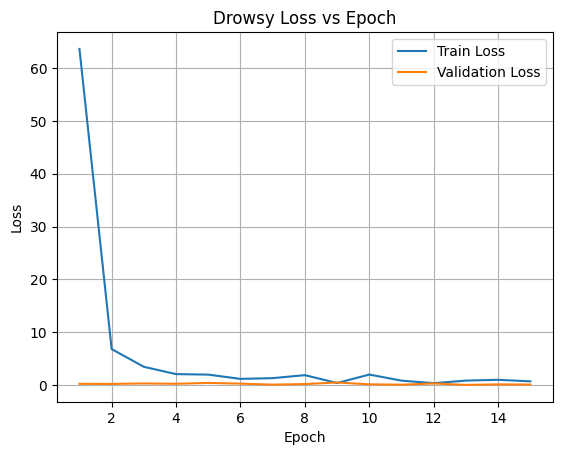

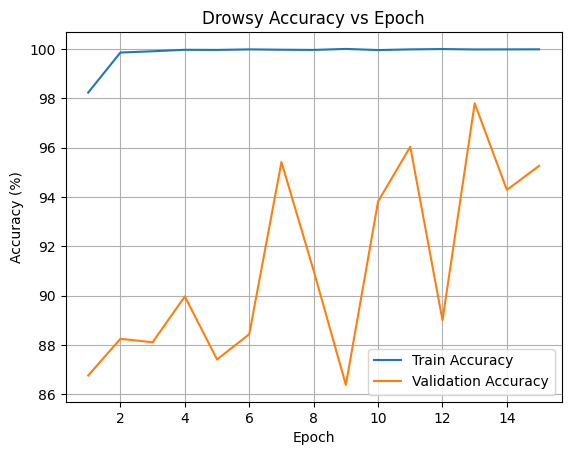

In [37]:
epochs = range(1, num_epochs + 1)

# Drowsy Loss
plt.figure()
plt.plot(epochs, train_d_losses, label='Train Loss')
plt.plot(epochs, val_d_losses, label='Validation Loss')
plt.title('Drowsy Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Drowsy Accuracy
plt.figure()
plt.plot(epochs, train_d_accs, label='Train Accuracy')
plt.plot(epochs, val_d_accs, label='Validation Accuracy')
plt.title('Drowsy Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

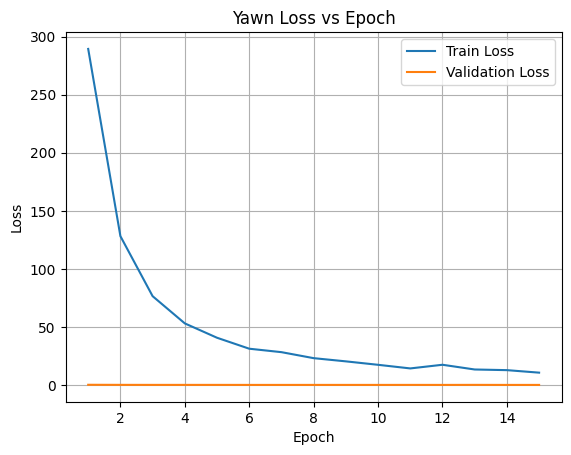

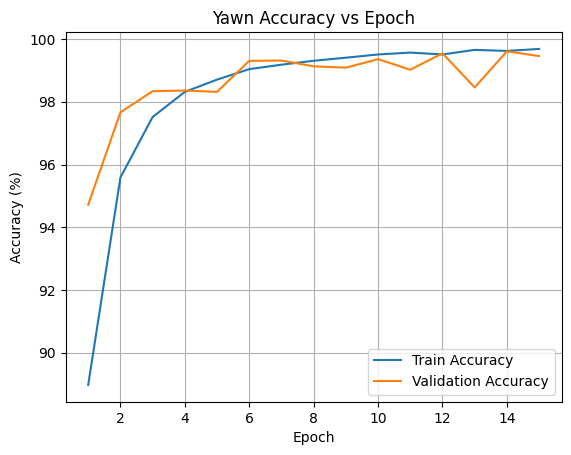

In [38]:
# Yawn Loss
plt.figure()
plt.plot(epochs, train_y_losses, label='Train Loss')
plt.plot(epochs, val_y_losses, label='Validation Loss')
plt.title('Yawn Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Yawn Accuracy
plt.figure()
plt.plot(epochs, train_y_accs, label='Train Accuracy')
plt.plot(epochs, val_y_accs, label='Validation Accuracy')
plt.title('Yawn Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
avg_train_d_acc = sum(train_d_accs) / len(train_d_accs)
avg_train_y_acc = sum(train_y_accs) / len(train_y_accs)
avg_val_d_acc = sum(val_d_accs) / len(val_d_accs)
avg_val_y_acc = sum(val_y_accs) / len(val_y_accs)

print(f'Average Training accuracy\n-> Drowsiness = {avg_train_d_acc:.2f}\n-> Yawning = {avg_train_y_acc:.2f}\nAverage Validation accuracy\n-> Drowsiness = {avg_val_d_acc:.2f}\n-> Yawning = {avg_val_y_acc:.2f}')

Average Training accuracy
-> Drowsiness = 99.84
-> Yawning = 98.24
Average Validation accuracy
-> Drowsiness = 91.19
-> Yawning = 98.64


In [39]:
torch.save(model.state_dict(), "models/model1_W.pth")

In [40]:
torch.save(model, "models/model1_full.pth")